Exploring ways to delineate irrigated cropping areas in NSW

### load libraries

In [3]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import datacube 
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking

import sys
sys.path.append('src/10_Scripts')
import DEAPlotting, SpatialTools, BandIndices
sys.path.append('src')
from transform_tuple import transform_tuple
from MAD import MAD

dc = datacube.Datacube(app='irrigated_areas')

## User Inputs

In [4]:
#Forbes# -33.386631, 148.001984 
#Gunedah -31.145867, 150.383842
#tamworth -31.105232, 150.937345
#cooryong -36.200347, 147.903574  garalema-29.496685, 149.064733
#Wagga waga -35.105587, 147.354434
AOI_name = 'tamworth'

load_fresh_data = False

lat, lon = -31.105232, 150.937345
latLon_adjust = 0.15
time_period = ('2016-01-01', '2017-12-31')

export_results = True
results = 'results/' + AOI_name + '_irrigated_201601_201712'

#thresholds
GI_std_threshold = 0.15
GI_max_threshold = 0.8
GI_med_threshold = 0.7

NDVI_std_threshold = 0.15
NDVI_max_threshold = 0.8
NDVI_med_threshold = 0.7

NDMI_threshold = 0.4
NDMI_std_threshold = 0.4

wofs_theshold = 0.15

## load data

In [5]:
if load_fresh_data == True:
# Set up query
    query = {'lon': (lon - latLon_adjust, lon + latLon_adjust),
             'lat': (lat - latLon_adjust, lat + latLon_adjust),
             'time': time_period}

    #load data
    xarray_dict = {}

    for sensor in ['ls8']:

        # Load data 
        landsat_ds = dc.load(product = f'{sensor}_nbart_albers', 
                             group_by = 'solar_day', 
                             **query)

        # Load PQ data 
        landsat_pq = dc.load(product = f'{sensor}_pq_albers', 
                             measurements = ['pixelquality'],
                             group_by = 'solar_day', 
                             **query)                       

        # Filter to subset of Landsat observations that have matching PQ data 
        time = (landsat_ds.time - landsat_pq.time).time
        landsat_ds = landsat_ds.sel(time=time)
        landsat_pq = landsat_pq.sel(time=time)

        # Create PQ mask
        good_quality = masking.make_mask(landsat_pq.pixelquality,
                                         cloud_acca='no_cloud',
                                         cloud_shadow_acca='no_cloud_shadow',
                                         cloud_shadow_fmask='no_cloud_shadow',
                                         cloud_fmask='no_cloud',
                                         blue_saturated=False,
                                         green_saturated=False,
                                         red_saturated=False,
                                         nir_saturated=False,
                                         contiguous=True) 

        # Apply mask to set all PQ-affected pixels to NaN and set nodata to NaN
        landsat_ds = landsat_ds.where(good_quality)

        # Add result to dict
        xarray_dict[sensor] = landsat_ds

    # Concatenate multiple sensors into one dataset
    landsat = xr.concat(xarray_dict.values(), dim='time')
    landsat = landsat_ds.sortby('time')

    #export out data so we dont need to reload everytime we need to clear the kernel
    datacube.storage.storage.write_dataset_to_netcdf(landsat, 'data/' + AOI_name + '_AOI_2016_2017.nc')

else:
    #load in data from saved netcdf file
    landsat = xr.open_dataset('data/' + AOI_name + '_AOI_2016_2017.nc')

In [6]:
query_wofs = {'lon': (lon - latLon_adjust, lon + latLon_adjust),
             'lat': (lat - latLon_adjust, lat + latLon_adjust)} 

dc = datacube.Datacube(app='wofs')
wofs_alltime = dc.load(product = 'wofs_summary', **query_wofs)

## band indices and stats

In [7]:
#calculate band indices
NDVI_landsat = BandIndices.calculate_indices(landsat, index='NDVI')
NDMI_landsat = BandIndices.calculate_indices(landsat, index='NDMI-nir')
GI_landsat = BandIndices.calculate_indices(landsat, index='GNDVI')

The formula we are using is (nir - red)/(nir + red)
The formula we are using is (nir - swir1)/(nir + swir1)
The formula we are using is (nir - green)/(nir + green)


In [8]:
#calculate per pixel summary stats
NDVI_std = NDVI_landsat.groupby('x','y').std('time').rename('NDVI_std')
NDVI_max = NDVI_landsat.groupby('x','y').max('time').rename('NDVI_max')
NDVI_med = NDVI_landsat.groupby('x','y').median('time').rename('NDVI_med')

GI_std = GI_landsat.groupby('x','y').std('time').rename('GNDVI_std')
GI_max = GI_landsat.groupby('x','y').max('time').rename('GNDVI_max')
GI_med = GI_landsat.groupby('x','y').median('time').rename('GNDVI_med')

NDMI_max = NDMI_landsat.groupby('x','y').max('time').rename('NDMI_max')
NDMI_std = NDMI_landsat.groupby('x','y').std('time').rename('NDMI_std')
NDMI_med = NDMI_landsat.groupby('x','y').median('time').rename('NDMI_med')

In [2]:
# GI_mad = MAD(GI_landsat)
# NDVI_mad = MAD(NDVI_landsat)

In [ ]:
# expprt band indices for exploration

# x = NDVI_landsat.to_dataset(name='NDVI')
# y = NDMI_landsat.to_dataset(name='NDMI')
# z = GI_landsat.to_dataset(name='GI')
# a = xr.merge([x,y,z])
# a.attrs=dict(crs=landsat.crs)

# datacube.storage.storage.write_dataset_to_netcdf(a, 'data/' + AOI_name + '_BANDINDICES_2016_2017.nc')

#Get the time of the maximum values, anti-correlated with rainfall??
# array.isel(x=array.argmax().item())

## data exploration plots

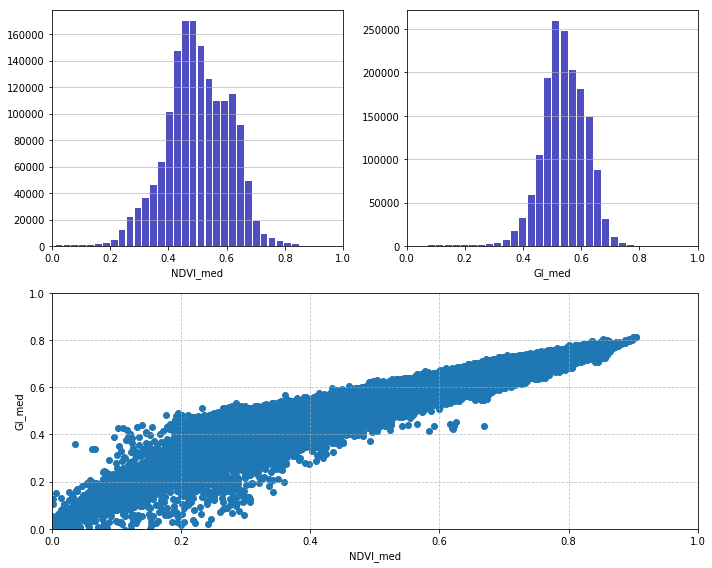

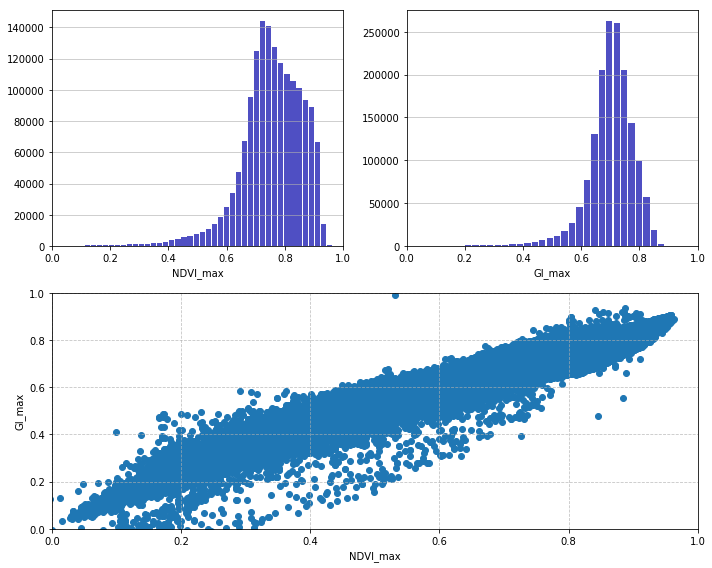

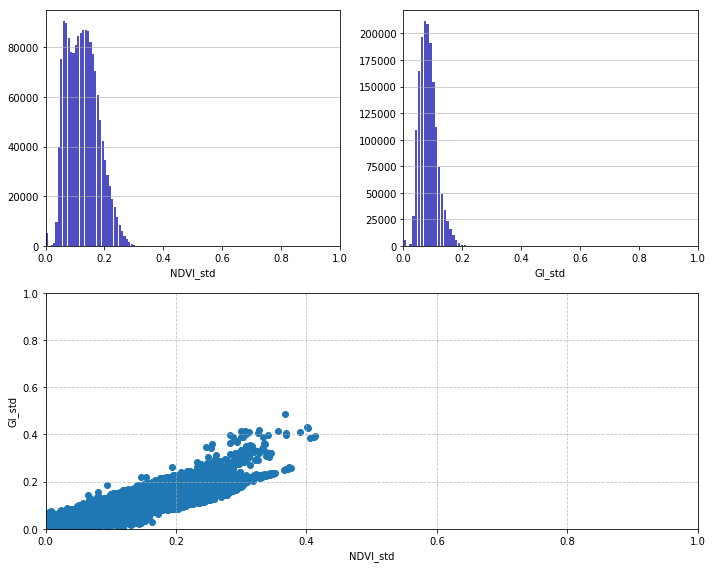

In [46]:
def explore_plots(summary_stat, variability_stat, bins = 50, thresholds = False):
    # generate data exploration plots for examining
    # thresholds

    gs = gridspec.GridSpec(2, 2)

    fig = plt.figure(figsize=(10,8))
    ax_p1 = fig.add_subplot(gs[0, 0])
    ax_p2 = fig.add_subplot(gs[0, 1])
    ax_p3 = fig.add_subplot(gs[1, :])
       
    ax_p1.hist(variability_stat.values.flatten()[~np.isnan(variability_stat.values.flatten())], #gotta deal with nans
                bins=bins, color='#0504aa', alpha=0.7, rwidth=0.85)
    ax_p1.grid(axis='y', alpha=0.75)
    ax_p1.set_xlabel(variability_stat.name)
    ax_p1.set_xlim(0,1)
    
    ax_p2.hist(summary_stat.values.flatten()[~np.isnan(summary_stat.values.flatten())], 
                bins=bins,color='#0504aa', alpha=0.7, rwidth=0.85)
    ax_p2.grid(axis='y', alpha=0.75)
    ax_p2.set_xlabel(summary_stat.name)
    ax_p2.set_xlim(0,1)
    
    ax_p3.scatter(variability_stat.values, summary_stat.values, marker = 'o')
    ax_p3.set_ylabel(summary_stat.name)
    ax_p3.set_xlabel(variability_stat.name)
    if thresholds == True:
        ax_p3.axvline(x=summary_threshold,  c='red', linestyle='dashed')
        ax_p3.axhline(y=variability_threshold, c='green', linestyle='dashed')
    ax_p3.grid(alpha=0.75, linestyle='--')
    ax_p3.set_xlim(0,1)
    ax_p3.set_ylim(0,1)
    
    plt.tight_layout()

explore_plots(GI_med, NDVI_med)
explore_plots(GI_max, NDVI_max)
explore_plots(GI_std, NDVI_std)

## reclassify

In [56]:
def reclassify(da, threshold, ins=1, out=0):
    da_np = da.values
    da_np = np.where(da_np >= threshold, ins, out)
    da_np = da_np.astype(bool)
    return da_np

GI_std_np = reclassify(GI_std, GI_std_threshold)
GI_max_np = reclassify(GI_max, GI_max_threshold)
GI_med_np = reclassify(GI_med, GI_med_threshold)

NDVI_std_np = reclassify(NDVI_std, NDVI_std_threshold)
NDVI_max_np = reclassify(NDVI_max, NDVI_max_threshold)
NDVI_med_np = reclassify(GI_med, NDVI_med_threshold)

wof_alltime_np = reclassify(wofs_alltime.frequency, wofs_theshold, ins=0, out=1)

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until


## raster math

In [65]:
#raster math to arrive at irrigation areas
irrigated_areas = GI_max_np #+ GI_std_np 
irrigated_areas = np.where(irrigated_areas >= 1, 1, 0)
irrigated_areas = irrigated_areas.astype(bool)

#remove water
irrigated_areas = np.where(wofs_alltime_np, irrigated_areas, 0)
#[wofs_alltime_np] = 0
irrigated_areas = irrigated_areas.astype(bool)

#rebuild xarray
y = NDMI_max.coords['y']
x = NDMI_max.coords['x']
irrigated_areas_xr = xr.DataArray(irrigated_areas, coords = [y, x], dims = ['y', 'x'], name='irrigated_areas')

In [66]:
## count number of '1's'
ones = (irrigated_areas_xr.values == 1).sum()
area = (ones*(25*25)) / 1000000
print(ones)
print(area)

118185
73.865625


## plot and export tiff

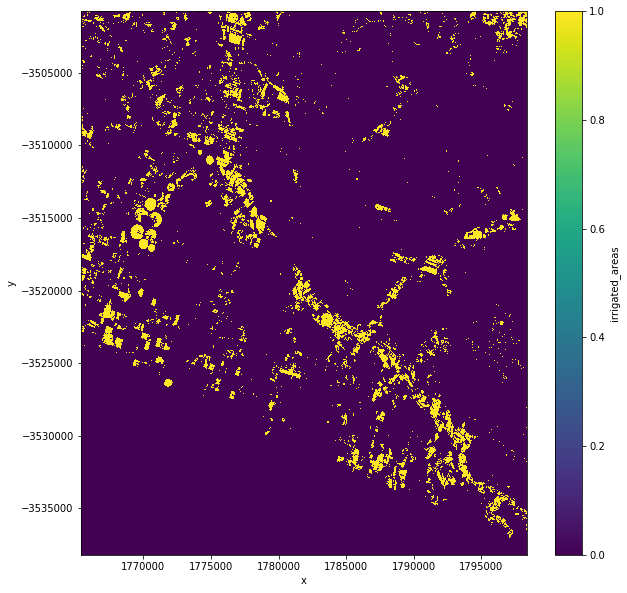

In [67]:
irrigated_areas_xr.plot(figsize=(10,10))

In [ ]:
#if export_results == True:
transform, projection = transform_tuple(irrigated_areas_xr, (irrigated_areas_xr.x, irrigated_areas_xr.y), epsg=3577)

SpatialTools.array_to_geotiff(results + '_GIMax9.0.tif',
              irrigated_areas_xr.values,
              geo_transform = transform, 
              projection = projection, 
              nodata_val=0)

## PCA/EOF analysis

In [72]:
# transform, projection = transform_tuple(irrigated_areas_xr, (irrigated_areas_xr.x, irrigated_areas_xr.y), epsg=3577)
# SpatialTools.array_to_geotiff(results + '_MaxGNDVI.tif',
#               GI_max.values,
#               geo_transform = transform, 
#               projection = projection, 
#               nodata_val=0)